In [ ]:
%cd ../assignment_2

In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

import pandas as pd
from scipy.ndimage import median_filter

from dash import Dash, html, dcc, callback, Output, Input
  

import stumpy
from numba import cuda

all_gpu_devices = [device.id for device in cuda.list_devices()]  # Get a list of all available GPU devices

# Helpful functions

In [4]:
def type_casting(df_in):
    df = df_in.copy()
    cat_features = ['store_id','region_id','order_id','status_id']
    float_feats = ['profit','order_price','max_price','min_price','avg_price','planned_prep_time']
    int_feats = ['delivery_distance','products_count','unique_products_sold_by_store']
    df[cat_features] = df[cat_features].astype('object')
    df[float_feats] = df[float_feats].astype('float')
    df[int_feats] = df[int_feats].astype('int')
    return df

In [5]:
def plot_time_series(df_regions: dict[str, pd.DataFrame]):
    _, ax = plt.subplots(len(df_regions), 1, 
                            figsize=(25, len(df_regions)*2.5))
    
    for idx, region_idx in enumerate(df_regions.keys()):
        sns.lineplot(df_regions[region_idx], ax=ax[idx])\
            .set_title(f'Order counts in region {region_idx}')
        plt.xlabel('Time')
        plt.ylabel('Order counts')
        plt.tight_layout()
    plt.show()

In [6]:
def group_by_region_id(df, resample=5) -> dict[str, pd.DataFrame]: 
    regions = df['region_id'].unique()
    df_regions = {}
    
    for region_id in regions:
        df_region = df[df['region_id']==region_id]

        df_grouped = df_region.groupby('date_create')['order_id'].agg('count')\
            .resample(f'{resample}min').agg({'order_id': 'sum'})
        df_regions[region_id] = df_grouped
    return df_regions

In [7]:
def sort_dates(df_in, date_columns):
    df = df_in.copy()
    mask_any_na_dates = df[date_columns].isna().any(axis=1)
    df.loc[~mask_any_na_dates, date_columns] = np.sort(df.loc[~mask_any_na_dates, date_columns].values, axis=1)
    return df

In [8]:
def scores(estimator, X_test, y_test, X_train, y_train, cv=5, cv_scoring=['f1'], threshold=0.5, plot=True, ax=None):
    pass

# EDA

In [ ]:
%cd ../assignment_2/

In [10]:
date_columns = ['date_create', 'order_start_prepare', 'order_ready', 'order_pickup']
orders = pd.read_csv('./content/df_forecasting.csv', parse_dates=date_columns)
orders = type_casting(orders)

In [11]:
df = sort_dates(orders, date_columns)
df['date_create'] = df['date_create'].ffill()

In [12]:
def dash_plot(motif_idx, nearest_neighbor_idx, region_id=683, default_window=15):

    app = Dash()

    app.layout = [
        html.H1(children='Orders frequency time series', style={'textAlign':'center'}),
        dcc.Dropdown(df['region_id'].unique(), region_id, id='region-selection'),
        dcc.Slider(0, 360, 5, value=default_window, id='window-slider', dots=False, tooltip = { 'always_visible': True }),
        dcc.Slider(0, 20000, 1, value=motif_idx, id='motif-slider', marks=None, tooltip = { 'always_visible': True }),
        dcc.Slider(0, 20000, 1, value=nearest_neighbor_idx, id='neighbor-slider', marks=None, tooltip = { 'always_visible': True }),
        dcc.Graph(id='graph-content'),
        html.Div(id='updatemode-output-container', style={'marginTop': 20})
    ]

    @callback(
            Output('updatemode-output-container', 'children'),
            Input('window-slider', 'value'),
            Input('motif-slider', 'value'),
            Input('neighbor-slider', 'value'))
    def display_value(window, motif, neighbor):
        return f'Window size: {window}'\
            f'\nMotif index: {motif}'\
            f'\nNeighbot index: {neighbor}'
        


    @callback(
        Output('graph-content', 'figure'),
        Input('region-selection', 'value'),
        Input('window-slider', 'value'),
        Input('motif-slider', 'value'),
        Input('neighbor-slider', 'value'),
    )
    def update_graph(region_id, window, motif, neighbor):
        df_regions = group_by_region_id(df, window)
        df_region = df_regions[region_id]
        
        fig1 = px.line(df_region).update_traces(opacity=.4)
        

        fig2 = px.line(df_region.iloc[motif:motif+window], color_discrete_sequence=['red'])
        fig3 = px.line(df_region.iloc[neighbor:neighbor+window], color_discrete_sequence=['olive'])
        
        fig1.add_traces(list(fig2.select_traces()))
        fig1.add_traces(list(fig3.select_traces()))
            
        
        fig1.update_xaxes(
                        rangeslider_visible=True,
                        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1d", step="day", stepmode="backward"),
                dict(count=7, label="1w", step="day", stepmode="backward"),
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        ))

        return fig1

    if __name__ == '__main__':
        app.run(host='0.0.0.0', port=9099, debug=True)

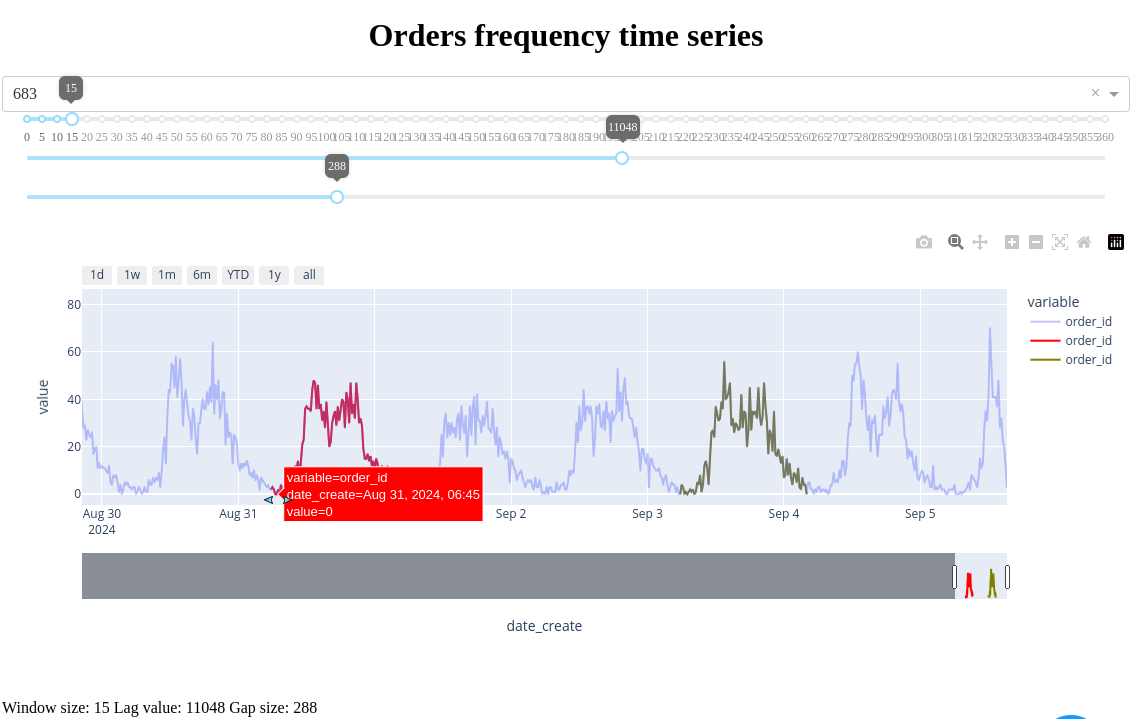

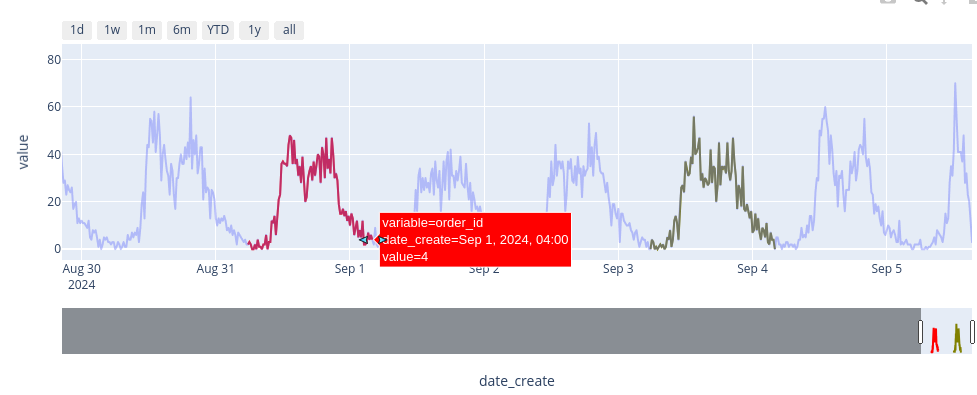

In [ ]:
df_regions = group_by_region_id(df.iloc[:30000], 15)
plot_time_series(df_regions)

In [14]:
n = 15
df_regions = group_by_region_id(df, n)

# Outlier Detection

In [15]:
X_train, X_test = train_test_split(df, train_size=0.9, shuffle=False)

In [ ]:
X_train_groups = group_by_region_id(X_train, 15)
plot_time_series(X_train_groups)

In [ ]:
X_test_groups = group_by_region_id(X_test, 15)
plot_time_series(X_test_groups)

In [18]:
from tqdm import tqdm

In [19]:
def matrix_profiles(X_groups, window_size=96, nearest_neighbor_distance_outliers = 3.0, max_outliers=5):
    mps = {}
    motif_idxs = {}
    discord_idxs = {}
    
    for region_idx, redion_data in tqdm(X_groups.items()):
        time_series = redion_data['order_id'].astype('float')
        mp = stumpy.gpu_stump(time_series, m=window_size, device_id=0)
        mps[region_idx] = mp
        nearest_neighbor_distance_outliers = mp.P_.mean()
        print('Minimum nearest neighbor distance for being outlier: ', nearest_neighbor_distance_outliers)


        motif_idx = np.argsort(mp.P_)[0] + window_size
        motif_idxs[region_idx] = [motif_idx, mp[motif_idx - window_size, 1] + window_size]
        
        discord_idx = np.argsort(mp.P_)[-1] + window_size
        discord_idxs[region_idx] = [(discord_idx, mp[discord_idx - window_size, 0])]
        for i in range(max_outliers):
            discord_idx = mp[discord_idx, 1]
            print('check: ', mp[discord_idx, 0])
            if (nearest_neighbor_distance := mp[discord_idx - window_size, 0]) > nearest_neighbor_distance_outliers:
                discord_idxs[region_idx].append((discord_idx, nearest_neighbor_distance))
                print("Discord: ", discord_idx, " added.")
            else:
                break

        print(f"Processing region {region_idx}...")
        print("Motif: ", motif_idx)
    return mps, motif_idxs, discord_idxs

In [ ]:
mps, motif_idxs, discord_idxs = matrix_profiles(X_train_groups, max_outliers=10)

In [21]:
def detect_outliers(mps, motif_idxs, discord_idxs, X_groups, window_size=96):
    for region_idx, redion_data in X_groups.items():
        time_series = redion_data['order_id'].astype('float')
        print(f"Processing region {region_idx}...")
        # Визуализация временного ряда и обнаруженных изменений
        fig = go.Figure()

        time_series = X_groups[region_idx]['order_id']
        # Добавляем временной ряд
        fig.add_trace(go.Scatter(
            x=time_series.index,  # Индексы временного ряда (время)
            y=time_series,        # Значения заказов
            mode='lines',
            name='Orders (time-series)',
            line=dict(color='blue'),
        ))
        # Добавляем Matrix Profile на вторичную ось Y
        fig.add_trace(go.Scatter(
            x=time_series.index[window_size - 1:],
            y=mps[region_idx].P_,
            mode='lines',
            name='Matrix Profile',
            line=dict(color='green', dash='dot'),
            yaxis='y2'
        ))

        print("Motifs:")
        # Добавляем точки изменений
        for loc in motif_idxs[region_idx]:
            print(loc)
            fig.add_trace(go.Scatter(
                x=[time_series.index[loc], time_series.index[loc]],
                y=[time_series.min(), time_series.max()],
                mode='lines',
                line=dict(color='red', dash='dash'),
                showlegend=False  # Отключаем повторяющуюся легенду для каждой линии
            ))
            fig.add_trace(go.Scatter(
                x=time_series[loc:loc+window_size].index,
                y=time_series[loc:loc+window_size],
                mode='lines',
                name='Motif (Pattern) Discovery',
                line=dict(color='red'),
                showlegend=True  
            ))

        print("Discords: ")
        for loc in discord_idxs[region_idx]:
            print(loc)
            fig.add_trace(go.Scatter(
                x=[time_series.index[loc[0]]],
                y=[time_series[loc[0]]],
                mode='markers',
                name='Potential Anomalies (Discords)',
                line=dict(color='cyan'),
                showlegend=False  # Отключаем повторяющуюся легенду для каждой линии
            ))

        # Настраиваем оси и внешний вид
        fig.update_layout(
            xaxis=dict(
                rangeselector=dict(
                    buttons=[
                        dict(count=1, label="1 Day", step="day", stepmode="backward"),
                        dict(count=7, label="1 Week", step="day", stepmode="backward"),
                        dict(count=1, label="1 Month", step="month", stepmode="backward"),
                        dict(step="all")
                    ]
                ),
                rangeslider=dict(visible=True),
                type="date"
            ),
            yaxis=dict(
                title='Number of Orders',
                titlefont=dict(color='blue'),
                tickfont=dict(color='blue')
            ),
            yaxis2=dict(
                title='Matrix Profile',
                titlefont=dict(color='green'),
                tickfont=dict(color='green'),
                anchor="x",
                overlaying="y",
                side="right"
            ),
            title=f'Region {region_idx} - Patterns and Matrix Profile',
            xaxis_title='Time',
            template='seaborn',
            legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
            width=1800
        )
        # Отображаем график
        fig.show()

In [ ]:
detect_outliers(mps, motif_idxs, discord_idxs, X_train_groups)

In [ ]:
X_train_groups.keys()

In [ ]:
motif_idxs, discord_idxs

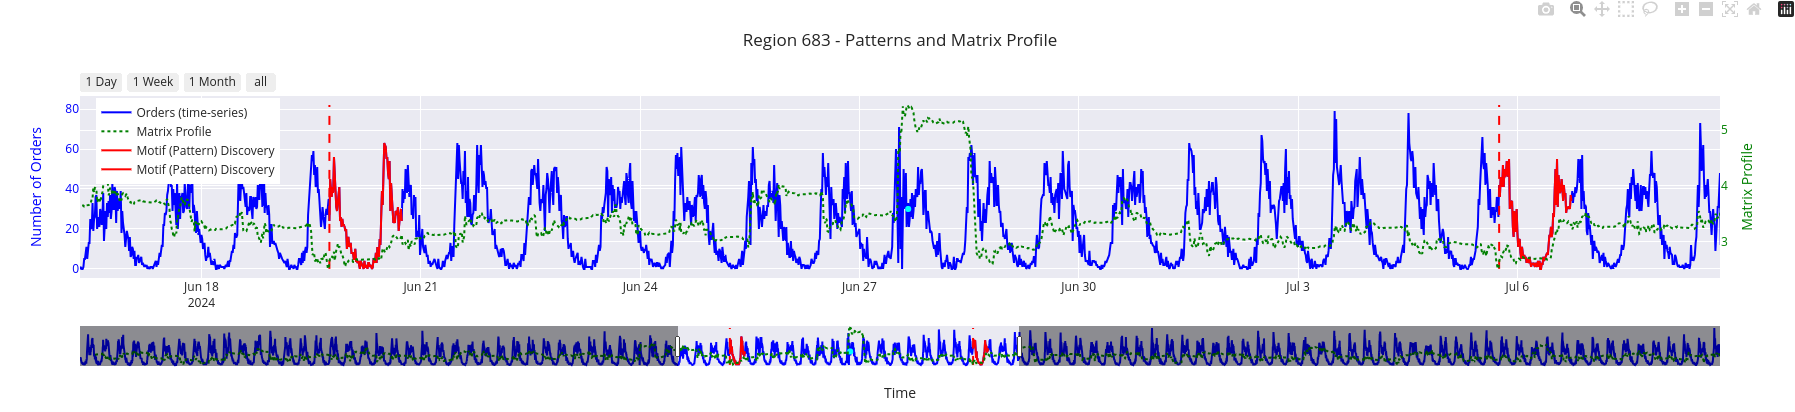

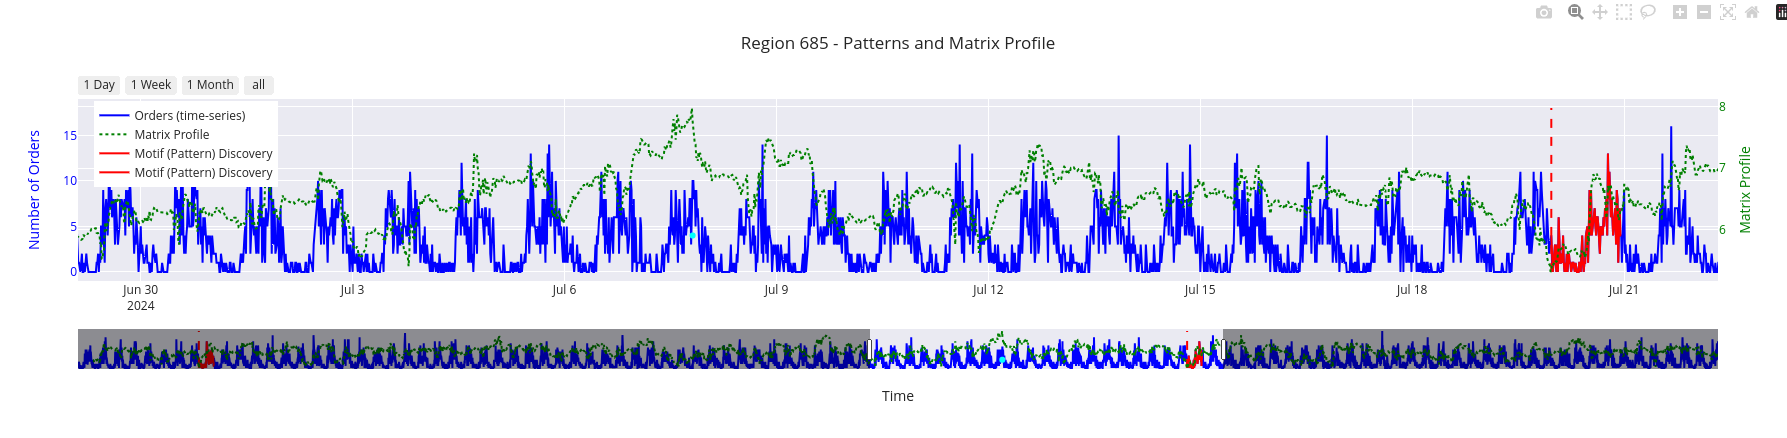

The visualizations provide insights into both patterns and anomalies within the time-series data for each region. Key findings:

Matrix Profile Representation: The green, dashed lines depict the matrix profile, effectively summarizing the similarity of sub-sequences. Regions with higher peaks in the matrix profile are more likely to contain anomalies (discords), whereas lower values suggest frequently recurring patterns (motifs).

Motifs (Patterns): The red segments on the graph indicate motifs—frequently occurring sequences of similar patterns in the data. For instance:
- Region 683 has motifs starting at indices 5640 and 4104.
- Region 685 has motifs at 763 and 7003.

These motifs reveal repetitive customer behavior, such as recurring peaks in orders.

Discords (Anomalies): Cyan markers represent discord locations—sub-sequences that are significantly different from the rest of the data. Potential anomalies may arise from unusual order spikes or drops, likely caused by external events or data issues. For example:
- Region 683 has a discord at index 4768 with a matrix profile value of 3.23.
- Region 685 has a discord at index 5740 with a value of 6.796.

Temporal Trends: The graphs illustrate fluctuations in orders, reflecting seasonality or cyclic behavior. For example:
    Some regions exhibit regular patterns, possibly linked to daily or weekly customer habits.
    Other regions display irregularities or sudden spikes, hinting at external factors impacting the order flow.

# Outlier Treatment

In [76]:
from copy import deepcopy

In [61]:
def treatment_outliers(data, discord_idxs, window_size = 96):

    data_smoothed = deepcopy(data)

    for region_idx, discord_data in discord_idxs.items():
        # Извлекаем временной ряд для текущего региона
        time_series = X_train_groups[region_idx]['order_id'].astype('float')
        # Создаем копию временного ряда для обработки выбросов
        cleaned_series = time_series.copy()

        # Проходим по списку выбросов, превышающих порог
        for discord_idx, discord_value in discord_data:
            cleaned_series[discord_idx:discord_idx + window_size] = np.nan

        # Заполняем выбросы линейной интерполяцией
        cleaned_series = pd.Series(cleaned_series).interpolate(method='linear', limit_direction='both').to_numpy()

        # Обновляем данные временного ряда
        data_smoothed[region_idx]['order_id'] = cleaned_series
    return data_smoothed

In [79]:
mps, motif_idxs, discord_idxs = matrix_profiles(X_train_groups, max_outliers=5)

  8%|███▍                                        | 1/13 [00:02<00:26,  2.21s/it]

Minimum nearest neighbor distance for being outlier:  3.2380572733921564
check:  2.708031532680042
Discord:  543  added.
check:  2.708031532680042
Discord:  4864  added.
check:  2.708031532680042
Discord:  543  added.
check:  2.708031532680042
Discord:  4864  added.
check:  2.708031532680042
Discord:  543  added.
Processing region 683...
Motif:  5640


 15%|██████▊                                     | 2/13 [00:03<00:20,  1.89s/it]

Minimum nearest neighbor distance for being outlier:  7.1860320709576735
check:  7.120020468786864
Discord:  2351  added.
check:  6.92184499445954
Processing region 703...
Motif:  3937


 23%|██████████▏                                 | 3/13 [00:06<00:21,  2.14s/it]

Minimum nearest neighbor distance for being outlier:  8.454981092654412
check:  6.907055886549714
Processing region 691...
Motif:  7464


 31%|█████████████▌                              | 4/13 [00:07<00:17,  1.95s/it]

Minimum nearest neighbor distance for being outlier:  4.812310597679571
check:  4.63233055239867
Discord:  3436  added.
check:  4.63233055239867
Discord:  3630  added.
check:  4.63233055239867
Discord:  3436  added.
check:  4.63233055239867
Discord:  3630  added.
check:  4.63233055239867
Discord:  3436  added.
Processing region 707...
Motif:  4147


 38%|████████████████▉                           | 5/13 [00:09<00:14,  1.83s/it]

Minimum nearest neighbor distance for being outlier:  6.378521136192952
check:  6.276208300259317
Processing region 695...
Motif:  2179


 46%|████████████████████▎                       | 6/13 [00:11<00:12,  1.76s/it]

Minimum nearest neighbor distance for being outlier:  9.088583569674668
check:  8.416831602067436
Discord:  2250  added.
check:  8.416831602067436
Discord:  8496  added.
check:  8.416831602067436
Discord:  2250  added.
check:  8.416831602067436
Discord:  8496  added.
check:  8.416831602067436
Discord:  2250  added.
Processing region 705...
Motif:  3832


 54%|███████████████████████▋                    | 7/13 [00:12<00:10,  1.72s/it]

Minimum nearest neighbor distance for being outlier:  7.78257106251076
check:  8.173623632842022
Discord:  5089  added.
check:  7.976962871480424
Discord:  3550  added.
check:  7.976962871480424
Processing region 689...
Motif:  7222


 62%|███████████████████████████                 | 8/13 [00:14<00:08,  1.69s/it]

Minimum nearest neighbor distance for being outlier:  8.204397368710307
check:  8.096072522245864
Processing region 709...
Motif:  3236


 69%|██████████████████████████████▍             | 9/13 [00:16<00:06,  1.67s/it]

Minimum nearest neighbor distance for being outlier:  7.567685577546458
check:  7.191737068710048
Processing region 693...
Motif:  7944


 77%|█████████████████████████████████          | 10/13 [00:17<00:04,  1.65s/it]

Minimum nearest neighbor distance for being outlier:  8.771144122471458
check:  8.057336064322461
Processing region 687...
Motif:  4979


 85%|████████████████████████████████████▍      | 11/13 [00:20<00:03,  1.91s/it]

Minimum nearest neighbor distance for being outlier:  6.485124039082566
check:  6.442277353580165
Processing region 685...
Motif:  763


 92%|███████████████████████████████████████▋   | 12/13 [00:21<00:01,  1.83s/it]

Minimum nearest neighbor distance for being outlier:  9.33713705132959
check:  9.091030572395844
Discord:  6885  added.
check:  9.091030572395844
Processing region 697...
Motif:  545


100%|███████████████████████████████████████████| 13/13 [00:23<00:00,  1.81s/it]

Minimum nearest neighbor distance for being outlier:  8.774244578461614
check:  9.204014449658045
Discord:  6451  added.
check:  9.204014449658045
Discord:  2897  added.
check:  9.204014449658045
Discord:  6451  added.
check:  9.204014449658045
Discord:  2897  added.
check:  9.204014449658045
Discord:  6451  added.
Processing region 717...
Motif:  6579


In [81]:
X_train_smoothed = treatment_outliers(X_train_groups, discord_idxs)

In [82]:
mps_smoothed, motif_smoothed_idxs, discord_smoothed_idxs = matrix_profiles(X_train_smoothed)
detect_outliers(mps_smoothed, motif_smoothed_idxs, discord_smoothed_idxs, X_rain_smoothed)


  8%|███▍                                        | 1/13 [00:02<00:28,  2.34s/it]

Minimum nearest neighbor distance for being outlier:  3.306954557308907
check:  3.720201047828522
Discord:  618  added.
check:  3.720201047828522
Discord:  4939  added.
check:  3.720201047828522
Discord:  618  added.
check:  3.720201047828522
Discord:  4939  added.
check:  3.720201047828522
Discord:  618  added.
Processing region 683...
Motif:  4960


 15%|██████▊                                     | 2/13 [00:03<00:21,  1.93s/it]

Minimum nearest neighbor distance for being outlier:  7.189560882610215
check:  7.14386880649309
Processing region 703...
Motif:  817


 23%|██████████▏                                 | 3/13 [00:05<00:17,  1.79s/it]

Minimum nearest neighbor distance for being outlier:  8.469116074542107
check:  7.575246178849759
Processing region 691...
Motif:  9307


 31%|█████████████▌                              | 4/13 [00:07<00:15,  1.74s/it]

Minimum nearest neighbor distance for being outlier:  4.832049490093316
check:  4.6228605449760956
Processing region 707...
Motif:  3533


 38%|████████████████▉                           | 5/13 [00:08<00:13,  1.71s/it]

Minimum nearest neighbor distance for being outlier:  6.408914619022302
check:  6.473390222075594
Discord:  5135  added.
check:  6.473390222075594
Discord:  4940  added.
check:  6.473390222075594
Discord:  5135  added.
check:  6.473390222075594
Discord:  4940  added.
check:  6.473390222075594
Discord:  5135  added.
Processing region 695...
Motif:  8419


 46%|████████████████████▎                       | 6/13 [00:10<00:11,  1.70s/it]

Minimum nearest neighbor distance for being outlier:  9.063223528342212
check:  8.403497750893665
Processing region 705...
Motif:  2347


 54%|███████████████████████▋                    | 7/13 [00:12<00:10,  1.68s/it]

Minimum nearest neighbor distance for being outlier:  7.757088452104767
check:  7.068965717386172
Processing region 689...
Motif:  4823


 62%|███████████████████████████                 | 8/13 [00:13<00:08,  1.67s/it]

Minimum nearest neighbor distance for being outlier:  8.171558531798315
check:  1.8376938508424456
Discord:  4353  added.
check:  1.5863591042006813
Discord:  4323  added.
check:  1.5863591042006813
Discord:  4348  added.
check:  1.5863591042006813
Discord:  4323  added.
check:  1.5863591042006813
Discord:  4348  added.
Processing region 709...
Motif:  4416


 69%|██████████████████████████████▍             | 9/13 [00:15<00:06,  1.66s/it]

Minimum nearest neighbor distance for being outlier:  7.559457720933765
check:  6.760813143155769
Processing region 693...
Motif:  4911


 77%|█████████████████████████████████          | 10/13 [00:17<00:04,  1.66s/it]

Minimum nearest neighbor distance for being outlier:  8.783319967199672
check:  8.007361099739287
Processing region 687...
Motif:  1427


 85%|████████████████████████████████████▍      | 11/13 [00:18<00:03,  1.65s/it]

Minimum nearest neighbor distance for being outlier:  6.505156896471265
check:  5.923351495702678
Discord:  1556  added.
check:  5.923351495702678
Discord:  4916  added.
check:  5.923351495702678
Discord:  1556  added.
check:  5.923351495702678
Discord:  4916  added.
check:  5.923351495702678
Discord:  1556  added.
Processing region 685...
Motif:  7003


 92%|███████████████████████████████████████▋   | 12/13 [00:20<00:01,  1.64s/it]

Minimum nearest neighbor distance for being outlier:  9.325890069590317
check:  8.749965315581928
Discord:  9565  added.
check:  8.749965315581928
Discord:  253  added.
check:  8.749965315581928
Discord:  9565  added.
check:  8.749965315581928
Discord:  253  added.
check:  8.749965315581928
Discord:  9565  added.
Processing region 697...
Motif:  545


100%|███████████████████████████████████████████| 13/13 [00:22<00:00,  1.73s/it]

Minimum nearest neighbor distance for being outlier:  8.78930131865116
check:  9.011261191079408
Discord:  4908  added.
check:  9.011261191079408
Discord:  6551  added.
check:  9.011261191079408
Discord:  4908  added.
check:  9.011261191079408
Discord:  6551  added.
check:  9.011261191079408
Discord:  4908  added.
Processing region 717...
Motif:  6478


NameError: name 'X_rain_smoothed' is not defined

In [ ]:
discord_smoothed_idxs

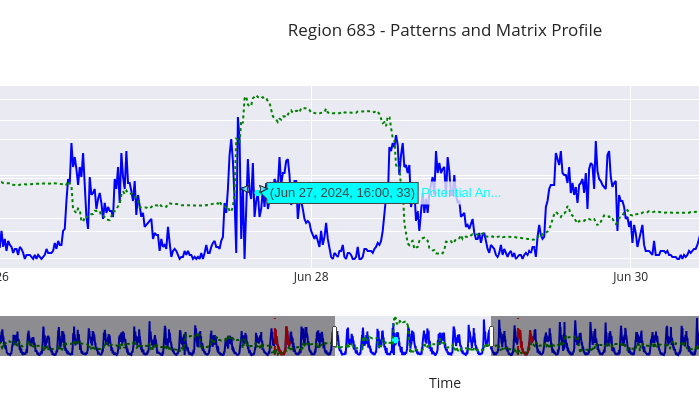


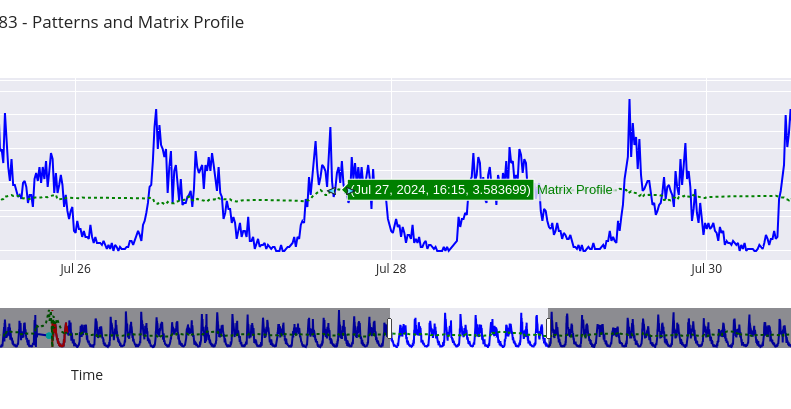

# Forecasting Future orders

In [83]:
from prophet import Prophet


def forecast_orders(data, order_column='order_id', timestamp_column='timestamp', n=30):
    """
    Forecast the number of orders for the next `n` minutes for each region.

    :param data: DataFrame with columns [region_column, order_column, timestamp_column].
    :param region_column: Name of the column containing the region identifier.
    :param order_column: Name of the column containing the number of orders.
    :param timestamp_column: Name of the column containing timestamps.
    :param n: Number of minutes to forecast into the future.
    :return: Dictionary with forecasts for each region.
    """
    forecasts = {}

    # Transform and process data for each region
    for region_id, region_data in data.items():
        # Prepare the data
        region_data = region_data.reset_index()
        region_data.columns = ['ds', 'y']  # Prophet requires these column names
        region_data['ds'] = pd.to_datetime(region_data['ds'])  # Ensure the column is datetime

        # Initialize and train the Prophet model
        model = Prophet()
        model.fit(region_data)

        # Generate future dataframe and make predictions
        future = model.make_future_dataframe(periods=n, freq='T')  # `n` minutes ahead
        forecast = model.predict(future)
        
        # Store the forecast
        forecasts[region_id] = forecast[['ds', 'yhat']]

    return forecasts


In [84]:
n = 30  # Specify the forecast horizon (e.g., next 30 minutes)
result = forecast_orders(X_test_groups, n=n)

# Example: View forecast for region 683
print(result[683])

20:47:27 - cmdstanpy - INFO - Chain [1] start processing


20:47:27 - cmdstanpy - INFO - Chain [1] done processing
20:47:27 - cmdstanpy - INFO - Chain [1] start processing
20:47:27 - cmdstanpy - INFO - Chain [1] done processing
20:47:28 - cmdstanpy - INFO - Chain [1] start processing
20:47:28 - cmdstanpy - INFO - Chain [1] done processing
20:47:28 - cmdstanpy - INFO - Chain [1] start processing
20:47:28 - cmdstanpy - INFO - Chain [1] done processing
20:47:29 - cmdstanpy - INFO - Chain [1] start processing
20:47:29 - cmdstanpy - INFO - Chain [1] done processing
20:47:29 - cmdstanpy - INFO - Chain [1] start processing
20:47:29 - cmdstanpy - INFO - Chain [1] done processing
20:47:29 - cmdstanpy - INFO - Chain [1] start processing
20:47:29 - cmdstanpy - INFO - Chain [1] done processing
20:47:30 - cmdstanpy - INFO - Chain [1] start processing
20:47:30 - cmdstanpy - INFO - Chain [1] done processing
20:47:30 - cmdstanpy - INFO - Chain [1] start processing
20:47:30 - cmdstanpy - INFO - Chain [1] done processing
20:47:30 - cmdstanpy - INFO - Chain [1] 

                      ds       yhat
0    2024-08-23 21:30:00  29.312854
1    2024-08-23 21:45:00  26.891954
2    2024-08-23 22:00:00  24.566160
3    2024-08-23 22:15:00  22.400525
4    2024-08-23 22:30:00  20.443975
...                  ...        ...
1249 2024-09-05 15:41:00  26.796433
1250 2024-09-05 15:42:00  26.708227
1251 2024-09-05 15:43:00  26.621914
1252 2024-09-05 15:44:00  26.537514
1253 2024-09-05 15:45:00  26.455048

[1254 rows x 2 columns]


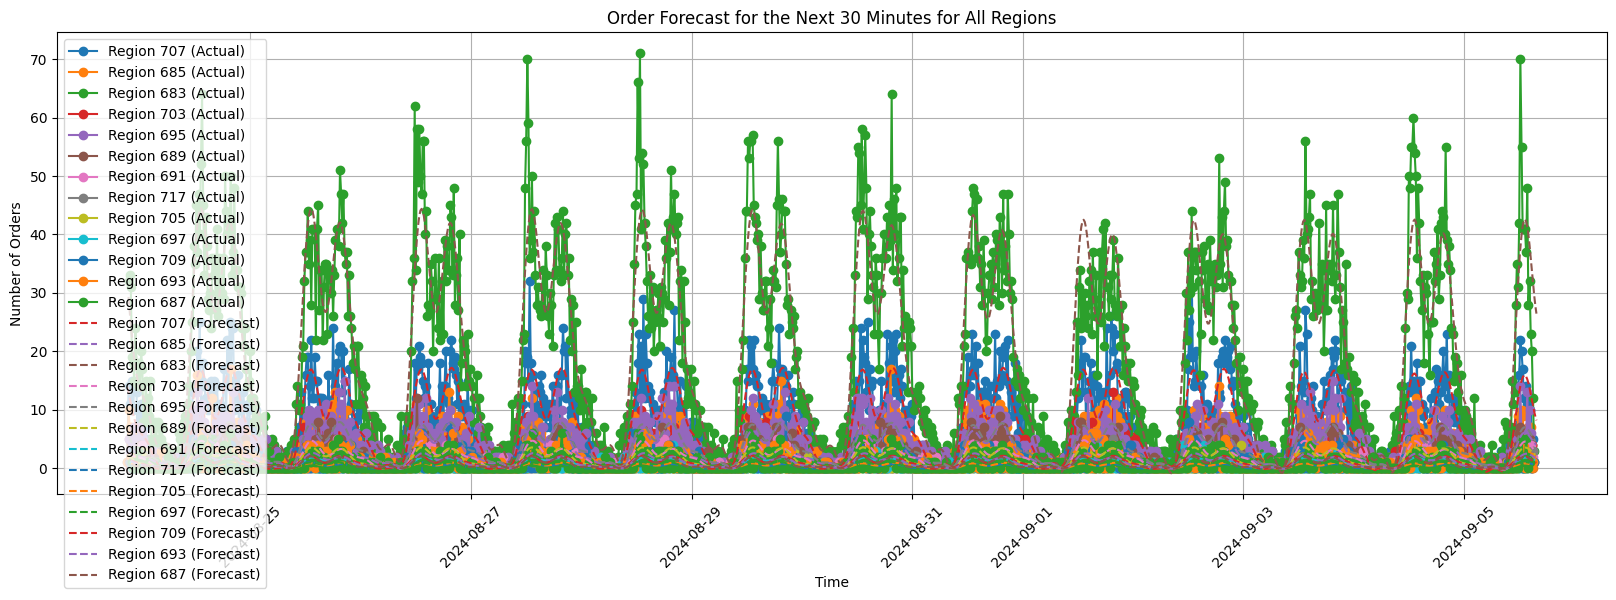

In [85]:
# Visualize the forecast
plt.figure(figsize=(20, 6))

# Plotting actual data
for region_id, region_data in X_test_groups.items():
    region_data = region_data.reset_index()
    region_data['date_create'] = pd.to_datetime(region_data['date_create'])
    plt.plot(region_data['date_create'], region_data['order_id'], label=f'Region {region_id} (Actual)', linestyle='-', marker='o')

# Plotting forecasted data
for region_id, forecast in result.items():
    plt.plot(forecast['ds'], forecast['yhat'], label=f'Region {region_id} (Forecast)', linestyle='--')

plt.title(f"Order Forecast for the Next {n} Minutes for All Regions")
plt.xlabel("Time")
plt.ylabel("Number of Orders")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()